In [1]:
import numpy as np
import random
from collections import defaultdict
import itertools
import time
import matplotlib.pyplot as plt
import pickle

def q_table_default():
    return np.zeros(4)

In [2]:
class MultiAgentDeliveryEnv:
    def __init__(self, grid_size=5, n_agents=4):
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.actions = ['N', 'S', 'E', 'W']
        self.action_map = {'N': (-1, 0), 'S': (1, 0), 'E': (0, 1), 'W': (0, -1)}
        self.max_steps = 25
        self.reset()
        
    def reset(self, A=None, B=None, agent_starts=None):
        if A is None or B is None:
            while True:
                A = (np.random.randint(self.grid_size), np.random.randint(self.grid_size))
                B = (np.random.randint(self.grid_size), np.random.randint(self.grid_size))
                if A != B:
                    break
        self.A = A
        self.B = B
        if agent_starts is None:
            agent_starts = [random.choice([A, B]) for _ in range(self.n_agents)]
        self.agent_pos = list(agent_starts)
        self.agent_carry = [pos == A for pos in agent_starts]
        self.agent_steps = [0 for _ in range(self.n_agents)]
        self.agent_delivered = [0 for _ in range(self.n_agents)]
        self.done = [False for _ in range(self.n_agents)]
        self.collisions = 0
        self.headon_collisions = 0
        self.step_count = 0
        return self._get_obs()
    
    def _get_obs(self):
        obs = []
        for i in range(self.n_agents):
            obs.append((self.agent_pos[i], self.A, self.B, self.agent_carry[i]))
        return obs
    
    def _move(self, pos, action):
        dx, dy = self.action_map[action]
        nx, ny = pos[0] + dx, pos[1] + dy
        nx = min(max(nx, 0), self.grid_size-1)
        ny = min(max(ny, 0), self.grid_size-1)
        return (nx, ny)
    
    def step(self, actions):
        order = list(range(self.n_agents))
        random.shuffle(order)
        next_pos = list(self.agent_pos)
        next_carry = list(self.agent_carry)
        rewards = [0 for _ in range(self.n_agents)]
        info = {'collisions': 0, 'headon_collisions': 0}
        
        intended_moves = []
        for i in order:
            if self.done[i]:
                intended_moves.append(self.agent_pos[i])
                continue
            new_pos = self._move(self.agent_pos[i], actions[i])
            intended_moves.append(new_pos)
        
        move_pairs = {}
        for idx, (old, new, carry) in enumerate(zip(self.agent_pos, intended_moves, self.agent_carry)):
            move_pairs[idx] = (old, new, carry)
        
        # Head-on collision detection
        for i, j in itertools.combinations(range(self.n_agents), 2):
            if self.done[i] or self.done[j]:
                continue
            if move_pairs[i][1] == move_pairs[j][0] and move_pairs[j][1] == move_pairs[i][0]:
                if move_pairs[i][2] != move_pairs[j][2]:
                    if move_pairs[i][1] != self.A and move_pairs[i][1] != self.B:
                        self.headon_collisions += 1
                        info['headon_collisions'] += 1
                        rewards[i] -= 100
                        rewards[j] -= 100
                        intended_moves[i] = self.agent_pos[i]
                        intended_moves[j] = self.agent_pos[j]
        
        # Allow multiple agents on same cell if all are carrying or all are not (except A/B)
        for pos in set(intended_moves):
            idxs = [i for i, p in enumerate(intended_moves) if p == pos and not self.done[i]]
            if len(idxs) > 1 and pos != self.A and pos != self.B:
                carries = [self.agent_carry[i] for i in idxs]
                if not (all(carries) or not any(carries)):
                    self.collisions += 1
                    info['collisions'] += 1
                    for i in idxs:
                        rewards[i] -= 50
                        intended_moves[i] = self.agent_pos[i]
        
        # Update positions and carrying
        for i in range(self.n_agents):
            if self.done[i]:
                continue
            prev_pos = self.agent_pos[i]
            self.agent_pos[i] = intended_moves[i]
            # Pickup/dropoff
            if self.agent_pos[i] == self.A:
                self.agent_carry[i] = True
            elif self.agent_pos[i] == self.B and self.agent_carry[i]:
                self.agent_carry[i] = False
                self.agent_delivered[i] += 1
                rewards[i] += 100  # Delivery reward
            # Reward shaping: distance to target
            target = self.B if self.agent_carry[i] else self.A
            prev_dist = abs(prev_pos[0]-target[0]) + abs(prev_pos[1]-target[1])
            new_dist = abs(self.agent_pos[i][0]-target[0]) + abs(self.agent_pos[i][1]-target[1])
            if new_dist < prev_dist:
                rewards[i] += 1
            elif new_dist > prev_dist:
                rewards[i] -= 1
            else:
                rewards[i] -= 0.2  # Small penalty for not progressing
            self.agent_steps[i] += 1
            if self.agent_steps[i] >= self.max_steps:
                self.done[i] = True
        # Small positive reward for each step without collision
        if info['collisions'] == 0 and info['headon_collisions'] == 0:
            for i in range(self.n_agents):
                if not self.done[i]:
                    rewards[i] += 1        
                    
        self.step_count += 1
        return self._get_obs(), rewards, self.done, info

In [3]:
class QLearningAgent:
    def __init__(self, grid_size=5, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999):
        self.grid_size = grid_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_table = defaultdict(q_table_default)  # Pickle-safe
        
    def obs_to_state(self, obs, all_agent_pos):
        pos, A, B, carry = obs
        # Danger flag: is another agent adjacent?
        danger = 0
        for other in all_agent_pos:
            if other != pos and abs(other[0]-pos[0]) + abs(other[1]-pos[1]) == 1:
                danger = 1
                break
        return (pos[0], pos[1], A[0], A[1], B[0], B[1], int(carry), danger)
    
    def select_action(self, obs, all_agent_pos):
        state = self.obs_to_state(obs, all_agent_pos)
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        return np.argmax(self.q_table[state])
    
    def update(self, obs, action, reward, next_obs, done, all_agent_pos, next_all_agent_pos):
        state = self.obs_to_state(obs, all_agent_pos)
        next_state = self.obs_to_state(next_obs, next_all_agent_pos)
        best_next = np.max(self.q_table[next_state])
        td_target = reward + (self.gamma * best_next * (not done))
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [4]:
n_agents = 4
grid_size = 5
n_episodes = 50000
max_steps = 25
reward_history = []
collision_history = []
headon_history = []
step_budget = 0
collision_budget = 0
start_time = time.time()

# Training metrics
train_success_count = 0
train_total_episodes = 0
train_collision_count = 0
train_step_count = 0

# Best episode tracking
best_reward = -float('inf')
best_paths = None
best_A = None
best_B = None
best_starts = None

agents = [QLearningAgent(grid_size=grid_size) for _ in range(n_agents)]
env = MultiAgentDeliveryEnv(grid_size=grid_size, n_agents=n_agents)

for ep in range(n_episodes):
    obs = env.reset()
    total_reward = 0
    total_collisions = 0
    total_headon = 0
    done = [False] * n_agents
    steps = 0
    episode_paths = [[pos] for pos in env.agent_pos]
    agent_steps = [0] * n_agents
    delivered = [0] * n_agents
    steps_since_B = [0] * n_agents
    reached_B = [False] * n_agents
    while not all(done):
        all_agent_pos = [env.agent_pos[i] for i in range(n_agents)]
        actions = []
        for i in range(n_agents):
            actions.append(agents[i].select_action(obs[i], all_agent_pos))
        next_obs, rewards, done, info = env.step([env.actions[a] for a in actions])
        next_all_agent_pos = [env.agent_pos[i] for i in range(n_agents)]
        for i in range(n_agents):
            agents[i].update(obs[i], actions[i], rewards[i], next_obs[i], done[i], all_agent_pos, next_all_agent_pos)
            episode_paths[i].append(env.agent_pos[i])
        obs = next_obs
        total_reward += sum(rewards)
        total_collisions += info['collisions'] + info['headon_collisions']
        steps += 1
        step_budget += 1
        collision_budget += total_collisions
    for agent in agents:
        agent.decay_epsilon()
    reward_history.append(total_reward)
    collision_history.append(total_collisions)
    headon_history.append(total_headon)
    train_total_episodes += 1
    train_collision_count += total_collisions
    train_step_count += steps

    # Training success: all agents delivered in ≤20 steps after reaching B, and no collisions
    # (for simplicity, use steps <= 20*n_agents and no collisions)
    if total_collisions == 0 and steps <= 20 * n_agents:
        train_success_count += 1

    # Best episode tracking
    if total_reward > best_reward:
        best_reward = total_reward
        best_paths = [list(p) for p in episode_paths]
        best_A = env.A
        best_B = env.B
        best_starts = [p[0] for p in episode_paths]

    if (ep+1) % 500 == 0:
        print(f"Episode {ep+1}, Reward: {total_reward}, Collisions: {total_collisions}, Head-on: {total_headon}, Epsilon: {agents[0].epsilon:.3f}")

runtime = time.time() - start_time

train_success_rate = 100 * train_success_count / train_total_episodes if train_total_episodes > 0 else 0

print(f"\nTraining episodes: {train_total_episodes}")
print(f"Performance level (training): {train_success_rate:.1f}% (episodes solved in ≤20 steps/agent and no collisions)")
print(f"Total number of collisions during training: {train_collision_count}")
print(f"Step budget (training): {step_budget} / 1,500,000")
print(f"Collision budget (training): {collision_budget} / 4,000")
print(f"Runtime (training): {runtime:.2f}s / 600s")

Episode 500, Reward: 95.19999999999997, Collisions: 0, Head-on: 0, Epsilon: 0.606
Episode 1000, Reward: 187.20000000000007, Collisions: 0, Head-on: 0, Epsilon: 0.368
Episode 1500, Reward: 376.40000000000003, Collisions: 2, Head-on: 0, Epsilon: 0.223
Episode 2000, Reward: -631.6000000000001, Collisions: 5, Head-on: 0, Epsilon: 0.135
Episode 2500, Reward: -427.9999999999999, Collisions: 5, Head-on: 0, Epsilon: 0.082
Episode 3000, Reward: -638.8000000000001, Collisions: 7, Head-on: 0, Epsilon: 0.050
Episode 3500, Reward: 455.20000000000016, Collisions: 5, Head-on: 0, Epsilon: 0.050
Episode 4000, Reward: -835.6000000000003, Collisions: 9, Head-on: 0, Epsilon: 0.050
Episode 4500, Reward: -229.19999999999993, Collisions: 3, Head-on: 0, Epsilon: 0.050
Episode 5000, Reward: 2046.7999999999997, Collisions: 0, Head-on: 0, Epsilon: 0.050
Episode 5500, Reward: -325.6000000000001, Collisions: 4, Head-on: 0, Epsilon: 0.050
Episode 6000, Reward: -784.0000000000001, Collisions: 7, Head-on: 0, Epsilon:

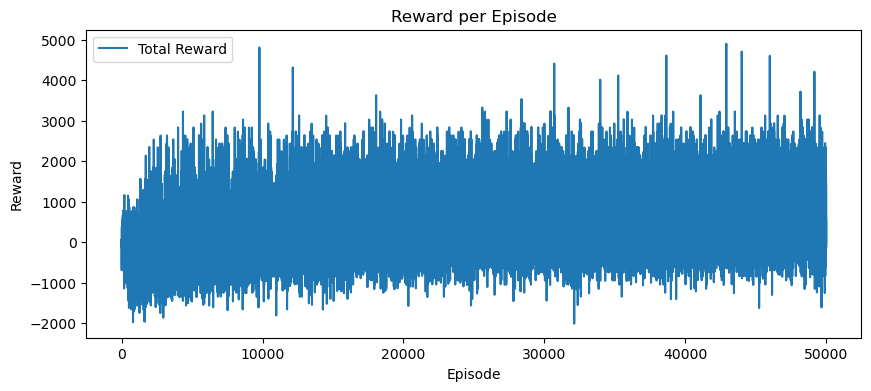

In [5]:
plt.figure(figsize=(10,4))
plt.plot(reward_history, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend()
plt.show()

In [6]:
# Save
with open('q_table_improved_2.pkl', 'wb') as f:
    pickle.dump([dict(agent.q_table) for agent in agents], f)

# Load (if needed)
# with open('q_table_improved.pkl', 'rb') as f:
#     q_tables = pickle.load(f)
#     for agent, q_table in zip(agents, q_tables):
#         agent.q_table = defaultdict(q_table_default, q_table)

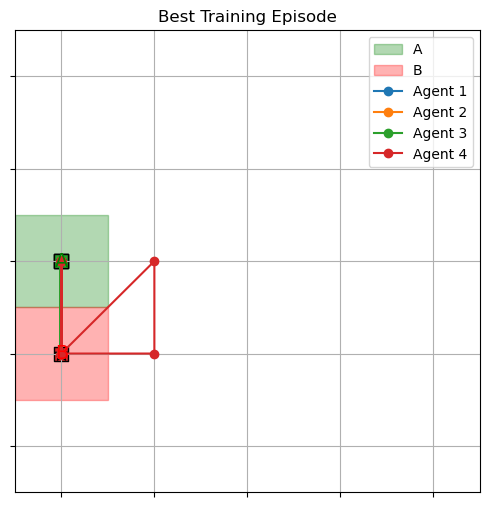

Best reward: 4899.6, A: (2, 0), B: (1, 0), Agent starts: [(2, 0), (2, 0), (2, 0), (1, 0)]


In [7]:
def plot_grid_episode(agent_paths, A, B, grid_size=5, title="Agent Movements"):
    n_agents = len(agent_paths)
    cmap = plt.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(-0.5, grid_size-0.5)
    ax.set_ylim(-0.5, grid_size-0.5)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    ax.set_title(title)
    ax.add_patch(plt.Rectangle((A[1]-0.5, A[0]-0.5), 1, 1, color='green', alpha=0.3, label='A'))
    ax.add_patch(plt.Rectangle((B[1]-0.5, B[0]-0.5), 1, 1, color='red', alpha=0.3, label='B'))
    ax.text(A[1], A[0], 'A', ha='center', va='center', fontsize=14, color='green')
    ax.text(B[1], B[0], 'B', ha='center', va='center', fontsize=14, color='red')
    for i, path in enumerate(agent_paths):
        xs = [p[1] for p in path]
        ys = [p[0] for p in path]
        ax.plot(xs, ys, marker='o', color=cmap(i), label=f'Agent {i+1}')
        ax.scatter(xs[0], ys[0], color=cmap(i), s=100, marker='s', edgecolor='k')
        ax.scatter(xs[-1], ys[-1], color=cmap(i), s=100, marker='*', edgecolor='k')
    ax.legend(loc='upper right')
    plt.show()

if best_paths is not None:
    plot_grid_episode(best_paths, best_A, best_B, grid_size=grid_size, title="Best Training Episode")
    print(f"Best reward: {best_reward}, A: {best_A}, B: {best_B}, Agent starts: {best_starts}")

In [12]:
import itertools
import time

# --- Evaluation Parameters ---
test_AB_samples = 30  # For speed, test 30 random A/B pairs (can increase for more thoroughness)

random.seed(42)
np.random.seed(42)

all_AB = [(a, b) for a in itertools.product(range(grid_size), repeat=2)
                  for b in itertools.product(range(grid_size), repeat=2) if a != b]
all_starts = list(itertools.product([0,1], repeat=n_agents))  # 0: A, 1: B

# Use a fixed sample for determinism
sampled_AB = all_AB[:test_AB_samples]

success_count = 0
total_scenarios = 0
collision_count = 0
step_count = 0

test_start_time = time.time()

for A, B in sampled_AB:
    for start_cfg in all_starts:
        agent_starts = [A if s == 0 else B for s in start_cfg]
        obs = env.reset(A=A, B=B, agent_starts=agent_starts)
        done = [False] * n_agents
        agent_steps = [0] * n_agents
        delivered = [0] * n_agents
        steps_since_B = [0] * n_agents
        reached_B = [False] * n_agents
        collisions = 0
        for t in range(100):  # Max 100 steps per scenario
            all_agent_pos = [env.agent_pos[i] for i in range(n_agents)]
            actions = []
            for i in range(n_agents):
                state = agents[i].obs_to_state(obs[i], all_agent_pos)
                actions.append(np.argmax(agents[i].q_table[state]))
            next_obs, rewards, done, info = env.step([env.actions[a] for a in actions])
            for i in range(n_agents):
                if not reached_B[i] and obs[i][0] == B:
                    reached_B[i] = True
                    steps_since_B[i] = 0
                if reached_B[i] and not done[i]:
                    steps_since_B[i] += 1
                if reached_B[i] and obs[i][0] == A and not obs[i][3]:  # At A, not carrying
                    delivered[i] = 1
            obs = next_obs
            collisions += info['collisions'] + info['headon_collisions']
            if all([r and d for r, d in zip(reached_B, delivered)]):
                break
        # Success: all agents did B->A->B in <=25 steps after reaching B, and no collisions
        if all([r and d for r, d in zip(reached_B, delivered)]) and max(steps_since_B) <= max_steps and collisions == 0:
            success_count += 1
        collision_count += collisions
        step_count += sum(steps_since_B)
        total_scenarios += 1

test_runtime = time.time() - test_start_time

success_rate = 100 * success_count / total_scenarios if total_scenarios > 0 else 0

print(f"Tested {total_scenarios} scenarios. Success rate: {success_rate:.1f}%")
print(f"Total test collisions: {collision_count}")
print(f"Total test steps: {step_count}\n")

print(f"Step budget (train+test): {step_budget + step_count} / 1,500,000")
print(f"Collision budget (train+test): {collision_budget + collision_count} / 4,000")
print(f"Runtime: {runtime + test_runtime:.2f}s / 600s")
print(f"Test success rate: {success_rate:.1f}% (target: ≥75%)")

Tested 480 scenarios. Success rate: 0.0%
Total test collisions: 735
Total test steps: 36377

Step budget (train+test): 1286377 / 1,500,000
Collision budget (train+test): 1575434 / 4,000
Runtime: 163.94s / 600s
Test success rate: 0.0% (target: ≥75%)


In [9]:
print("Final epsilon:", agents[0].epsilon)

Final epsilon: 0.05


In [10]:
print("Q-table size:", len(agents[0].q_table))

Q-table size: 50827


In [11]:
A, B = (0, 0), (4, 4)
agent_starts = [(0, 0), (0, 0), (0, 0), (0, 0)]

In [13]:
   for k, v in list(agents[0].q_table.items())[:5]:
       print(k, v)

(0, 4, 0, 4, 0, 0, 1, 1) [42.01137621 10.31932997  6.90815105 20.12513991]
(0, 4, 0, 4, 0, 0, 1, 0) [40.99002232 14.36891761 13.64397472  9.24354944]
(1, 4, 0, 4, 0, 0, 1, 1) [ 4.77719277 33.51901196  0.          0.        ]
(3, 4, 0, 4, 0, 0, 1, 1) [0.  0.2 0.  0. ]
(1, 0, 0, 4, 0, 0, 1, 0) [-4.01651382 17.33507561  0.          0.        ]
